In [1]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import gc
from tqdm import tqdm
import time
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

import pdb


# Defining global parameters

In [2]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": get_available_device(),
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=CONFIG['seed'])

# Read and split the data
## Validation set of 10% of the size

In [3]:
df = pd.read_pickle('enveda_chemist_preprocessed.pkl')
df.head()

,ground_truth_smiles,predicted_smiles,ground_truth_inchikey14,predicted_inchikey14,ground_truth_formula,predicted_formula,annotator_name,unable_to_assess,not_close_match,close_match,near_exact_match,exact_match,good_enough_for_prioritization,scaffold_correct,ground_truth_unable_to_annotate,ground_truth_has_scaffold,ground_truth_scaffold_smiles,ground_truth_scaffold_smarts,ground_truth_embeddings,predicted_embeddings
7,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,0,1,0,0,0,0,0,0,1,1,None,None,"[[0.5249032, 0.25463393, 1.1345547, 0.90460753...","[[0.96212196, 0.038500108, 0.9624641, 0.423108..."
8,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,1,1,0,0,0,0,0,0,1,1,None,None,"[[0.5249032, 0.25463393, 1.1345547, 0.90460753...","[[0.96212196, 0.038500108, 0.9624641, 0.423108..."
9,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,2,1,0,0,0,0,0,0,1,1,None,None,"[[0.5249032, 0.25463393, 1.1345547, 0.90460753...","[[0.96212196, 0.038500108, 0.9624641, 0.423108..."
10,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,3,0,1,0,0,0,0,1,0,1,c1cc2c(c3C=CCOc3cc2)[nH]1,[#6]1:[#6]:[#6]2:[#6](:[#6]3-[#6]=[#6]-[#6]-[#...,"[[0.5249032, 0.25463393, 1.1345547, 0.90460753...","[[0.96212196, 0.038500108, 0.9624641, 0.423108..."
11,CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...,CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...,WZHCMAFZIFECCV,PYHKDROAWLAEDE,C52H54N6O7,C26H29N3O4,4,1,0,0,0,0,0,0,1,1,None,None,"[[0.5249032, 0.25463393, 1.1345547, 0.90460753...","[[0.96212196, 0.038500108, 0.9624641, 0.423108..."


In [4]:
train_df, valid_df = train_test_split(df, test_size=0.1)

## Wrapping in Pytorch Dataset

In [5]:
class EnvedaDataset(Dataset):
    def __init__(self, dataframe, labels = ['unable_to_assess', 'close_match', 
                                            'near_exact_match', 'exact_match']):
        """
        Args:
            dataframe (pd.DataFrame): A DataFrame containing 'ground_truth_embeddings', 
                                       'predicted_embeddings', and output columns.
        """
        self.dataframe = dataframe
        
        # Convert embeddings to tensors
        self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)
        self.predicted_embeddings = torch.tensor(dataframe['predicted_embeddings'].tolist(), dtype=torch.float32)
        
        # Convert labels to tensor
        self.labels = torch.tensor(dataframe[labels].values, dtype=torch.float32)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        return self.ground_truth_embeddings[idx].squeeze(0), self.predicted_embeddings[idx].squeeze(0), self.labels[idx]


In [9]:
#---
trainset_unable = EnvedaDataset(dataframe=train_df, labels=['unable_to_assess'])
validset_unable = EnvedaDataset(dataframe=valid_df, labels=['unable_to_assess'])

#---
trainset_close = EnvedaDataset(dataframe=train_df, labels=['close_match'])
validset_close = EnvedaDataset(dataframe=valid_df, labels=['close_match'])

#--
trainset_near = EnvedaDataset(dataframe=train_df, labels=['near_exact_match'])
validset_near = EnvedaDataset(dataframe=valid_df, labels=['near_exact_match'])

#--
trainset_exact = EnvedaDataset(dataframe=train_df, labels=['exact_match'])
validset_exact = EnvedaDataset(dataframe=valid_df, labels=['exact_match'])

#--
trainset_prioritization = EnvedaDataset(dataframe=train_df, labels=['good_enough_for_prioritization'])
validset_prioritization = EnvedaDataset(dataframe=valid_df, labels=['good_enough_for_prioritization'])


## Wrapping in Pytorch DataLoader

In [11]:
trainloader_unable = DataLoader(trainset_unable, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_unable = DataLoader(validset_unable, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_close = DataLoader(trainset_close, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_close = DataLoader(validset_close, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_near = DataLoader(trainset_near, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_near = DataLoader(validset_near, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_exact = DataLoader(trainset_exact, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_exact = DataLoader(validset_exact, batch_size=CONFIG['valid_batch_size'], shuffle=False)

trainloader_prioritization = DataLoader(trainset_prioritization, batch_size=CONFIG['train_batch_size'], shuffle=True)
validloader_prioritization = DataLoader(validset_prioritization, batch_size=CONFIG['valid_batch_size'], shuffle=False)

In [12]:
gt, pred, labels = next(iter(trainloader_unable))
print(gt.shape, pred.shape, labels.shape)


torch.Size([16, 768]) torch.Size([16, 768]) torch.Size([16, 1])


# Defining neural network

In [15]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim=768, output_dim=4):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16 * 2, output_dim)  # Output layer for similarity judgements

    def forward_one(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return x

    def forward(self, input1, input2):
        out1 = self.forward_one(input1)
        out2 = self.forward_one(input2)
        # pdb.set_trace()
        # Combine both outputs by concatenation
        combined = torch.concat((out1, out2), dim=1) # concatenate embeddings
        output = self.fc5(combined)                  # Outputs raw logits
        return output
    
# model = SiameseNetwork(output_dim=1)
# model(gt, pred)

# Training and validation regime

## Training with mixed precision, gradient accumulation, learning with scheduler
## Validation logging loss, AUROC, and F1 metrics

In [29]:
def train_one_epoch(model, optimizer, criterion, scheduler, dataloader, epoch=CONFIG['epochs']):
    model.train()
    
    scaler = GradScaler()
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    running_f1 = 0.0
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = gt.shape[0]

        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
            
        # Backward pass with scaling
        scaler.scale(loss).backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            # Step the optimizer
            scaler.step(optimizer)

            # Update the scale for next iteration
            scaler.update()
            # optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        # pdb.set_trace()
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        # pdb.set_trace()
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc, Train_F1=epoch_f1,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

@torch.no_grad()
def valid_one_epoch(model, dataloader, criterion, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    running_f1 = 0.0 
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = gt.shape[0]
        
        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
        
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc, 
                        Valid_F1=epoch_f1,
                        )   
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

## Initializing components
1. Model
2. AdamW optimizer
3. Cosine annealing scheduler
4. Weighted cross entropy loss to handle class imbalance

In [30]:
# Define models, optimizers, and schedulers for each dataset
model_unable = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_unable = optim.AdamW(model_unable.parameters(), lr=CONFIG['learning_rate'], 
                               weight_decay=CONFIG['weight_decay'])
scheduler_unable = lr_scheduler.CosineAnnealingLR(optimizer_unable, T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])

model_close = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_close = optim.AdamW(model_close.parameters(), lr=CONFIG['learning_rate'], 
                               weight_decay=CONFIG['weight_decay'])
scheduler_close = lr_scheduler.CosineAnnealingLR(optimizer_close, T_max=CONFIG['T_max'], 
                                                 eta_min=CONFIG['min_lr'])

model_near = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_near = optim.AdamW(model_near.parameters(), lr=CONFIG['learning_rate'], 
                             weight_decay=CONFIG['weight_decay'])
scheduler_near = lr_scheduler.CosineAnnealingLR(optimizer_near, T_max=CONFIG['T_max'], 
                                                eta_min=CONFIG['min_lr'])

model_exact = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_exact = optim.AdamW(model_exact.parameters(), lr=CONFIG['learning_rate'], 
                               weight_decay=CONFIG['weight_decay'])
scheduler_exact = lr_scheduler.CosineAnnealingLR(optimizer_exact, T_max=CONFIG['T_max'], 
                               eta_min=CONFIG['min_lr'])

model_prioritization = SiameseNetwork(output_dim=1).to(CONFIG['device'])
optimizer_prioritization = optim.AdamW(model_prioritization.parameters(), lr=CONFIG['learning_rate'], 
                                       weight_decay=CONFIG['weight_decay'])
scheduler_prioritization = lr_scheduler.CosineAnnealingLR(optimizer_prioritization, T_max=CONFIG['T_max'],
                                                          eta_min=CONFIG['min_lr'])
                          

In [31]:

print(df[['unable_to_assess','close_match', 'near_exact_match','exact_match', 'good_enough_for_prioritization']].sum())
class_distribution = {'unable_to_assess': 73, 
                      'close_match': 605, 
                      'near_exact_match': 360, 
                      'exact_match': 73,
                      'good_enough_for_prioritization': 958}

# Calculate class weights
total_samples = sum(class_distribution.values())
class_weights = {label: total_samples / (len(class_distribution) * count) for label, count in class_distribution.items()}
print(class_weights)

# Convert class weights to tensors for each dataset
pos_weights_unable = torch.tensor([class_weights['unable_to_assess']]).to(CONFIG['device'])
pos_weights_close = torch.tensor([class_weights['close_match']]).to(CONFIG['device'])
pos_weights_near = torch.tensor([class_weights['near_exact_match']]).to(CONFIG['device'])
pos_weights_exact = torch.tensor([class_weights['exact_match']]).to(CONFIG['device'])
pos_weights_prioritization = torch.tensor([class_weights['good_enough_for_prioritization']]).to(CONFIG['device'])

# Define the BCEWithLogitsLoss for each dataset
criterion_unable = nn.BCEWithLogitsLoss(pos_weight=pos_weights_unable)
criterion_close = nn.BCEWithLogitsLoss(pos_weight=pos_weights_close)
criterion_near = nn.BCEWithLogitsLoss(pos_weight=pos_weights_near)
criterion_exact = nn.BCEWithLogitsLoss(pos_weight=pos_weights_exact)
criterion_prioritization = nn.BCEWithLogitsLoss(pos_weight=pos_weights_prioritization)



unable_to_assess                   73
close_match                       605
near_exact_match                  360
exact_match                        73
good_enough_for_prioritization    958
dtype: int64
{'unable_to_assess': 5.668493150684932, 'close_match': 0.6839669421487603, 'near_exact_match': 1.1494444444444445, 'exact_match': 5.668493150684932, 'good_enough_for_prioritization': 0.43194154488517744}


In [34]:
# # train_one_epoch(model=model_exact, optimizer=optimizer_exact, criterion=criterion_exact, scheduler=scheduler_exact, dataloader=trainloader_exact)
# valid_one_epoch(model=model_prioritization, dataloader=trainloader_prioritization, criterion=criterion_prioritization, epoch=CONFIG['epochs'])

## Putting all together into training code
Training code includes:
1. Early stopping
2. Saving best model weights according to supplied name
3. Original code adapted from Kaggle

In [35]:

def run_training(model, optimizer, scheduler, criterion, num_epochs, train_loader, valid_loader, name):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_f1 = -np.inf
    best_valid_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc, train_epoch_f1 = train_one_epoch(model=model, optimizer=optimizer, scheduler=scheduler, 
                                           criterion=criterion, dataloader=train_loader, 
                                           epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, val_epoch_f1 = valid_one_epoch(model=model, dataloader=valid_loader, criterion=criterion, 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['Valid F1'].append(val_epoch_f1)
        history['lr'].append( scheduler.get_lr()[0] )
        if val_epoch_loss <= best_valid_loss:
            print(f"Validation Loss Improved ({best_valid_loss} ---> {val_epoch_loss})")
            best_valid_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_VAL_LOSS_model_{name}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
        
        if best_epoch_f1 <= val_epoch_f1:
            print(f"Validation F1 Improved ({best_epoch_f1} ---> {val_epoch_f1})")
            best_epoch_f1 = val_epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_F1_model_{name}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best F1: {:.4f}".format(best_epoch_f1))
    print("Best Loss: {:.4f}".format(best_valid_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [36]:

# # Training for 'unable_to_assess'
# model_unable_trained, history_unable = run_training(model=model_unable, 
#                                                     optimizer=optimizer_unable, 
#                                                     scheduler=scheduler_unable, 
#                                                     criterion=criterion_unable, 
#                                                     num_epochs=100, 
#                                                     train_loader=trainloader_unable, 
#                                                     valid_loader=validloader_unable, 
#                                                     name='siamese_unable')

# # Training for 'close_match'
# model_close_trained, history_close = run_training(model=model_close, 
#                                                   optimizer=optimizer_close, 
#                                                   scheduler=scheduler_close, 
#                                                   criterion=criterion_close, 
#                                                   num_epochs=100, 
#                                                   train_loader=trainloader_close, 
#                                                   valid_loader=validloader_close, 
#                                                   name='siamese_close')

# # Training for 'near_exact_match'
# model_near_trained, history_near = run_training(model=model_near, 
#                                                 optimizer=optimizer_near, 
#                                                 scheduler=scheduler_near, 
#                                                 criterion=criterion_near, 
#                                                 num_epochs=100, 
#                                                 train_loader=trainloader_near, 
#                                                 valid_loader=validloader_near, 
#                                                 name='siamese_near')

# # Training for 'exact_match'
# model_exact_trained, history_exact = run_training(model=model_exact, 
#                                                   optimizer=optimizer_exact, 
#                                                   scheduler=scheduler_exact, 
#                                                   criterion=criterion_exact, 
#                                                   num_epochs=100, 
#                                                   train_loader=trainloader_exact, 
#                                                   valid_loader=validloader_exact, 
#                                                   name='siamese_exact')

# # Training for 'good_enough_for_prioritization'
# model_prioritization_trained, history_prioritization = run_training(model=model_prioritization,
#                                                                   optimizer=optimizer_prioritization,
#                                                                   scheduler=scheduler_prioritization,
#                                                                   criterion=criterion_prioritization,
#                                                                   num_epochs=100,
#                                                                   train_loader=trainloader_prioritization,
#                                                                   valid_loader=validloader_prioritization,
#                                                                   name='siamese_prioritization')


In [ ]:
import concurrent.futures

# Define a function to run the training for a single model
def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, name):
    return run_training(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        num_epochs=100,
        train_loader=train_loader,
        valid_loader=valid_loader,
        name=name
    )

# Prepare model-specific parameters
model_params = [
    (model_unable, optimizer_unable, scheduler_unable, criterion_unable, trainloader_unable, validloader_unable, 'siamese_unable'),
    (model_close, optimizer_close, scheduler_close, criterion_close, trainloader_close, validloader_close, 'siamese_close'),
    (model_near, optimizer_near, scheduler_near, criterion_near, trainloader_near, validloader_near, 'siamese_near'),
    (model_exact, optimizer_exact, scheduler_exact, criterion_exact, trainloader_exact, validloader_exact, 'siamese_exact'),
    (model_prioritization, optimizer_prioritization, scheduler_prioritization, criterion_prioritization, trainloader_prioritization, validloader_prioritization, 'siamese_prioritization')
]

# Use ThreadPoolExecutor to parallelize the training
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(train_model, *params): name for params, name in zip(model_params, ['siamese_unable', 'siamese_close', 'siamese_near', 'siamese_exact', 'siamese_prioritization'])}
    
    for future in concurrent.futures.as_completed(futures):
        model_name = futures[future]
        try:
            trained_model, history = future.result()
            print(f"Training completed for model: {model_name}")
        except Exception as e:
            print(f"Model {model_name} generated an exception: {e}")


# Plotting training metrics

In [26]:
def plot_metrics(metrics_dict):
    epochs = range(1, len(metrics_dict['Train Loss']) + 1)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # Plot Train and Validation Loss
    axs[0].plot(epochs, metrics_dict['Train Loss'], label='Train Loss', color='blue', marker='o')
    axs[0].plot(epochs, metrics_dict['Valid Loss'], label='Valid Loss', color='orange', marker='o')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot Train and Validation AUROC
    axs[1].plot(epochs, metrics_dict['Train AUROC'], label='Train AUROC', color='green', marker='o')
    axs[1].plot(epochs, metrics_dict['Valid AUROC'], label='Valid AUROC', color='red', marker='o')
    axs[1].set_title('AUROC Over Epochs')
    axs[1].set_ylabel('AUROC Score')
    axs[1].legend()
    axs[1].grid()

    
    # Plot Validation F1 Score
    axs[2].plot(epochs, metrics_dict['Valid F1'], label='Valid F1 Score', color='purple', marker='o')
    axs[2].set_title('Validation F1 Score Over Epochs')
    axs[2].set_ylabel('F1 Score')
    
    
    # Create a separate plot for Learning Rate
    fig_lr, ax_lr = plt.subplots(figsize=(10, 5))
    ax_lr.plot(epochs, metrics_dict['lr'], label='Learning Rate', color='cyan', linestyle='--', marker='o')
    ax_lr.set_title('Learning Rate Over Epochs')
    ax_lr.set_ylabel('Learning Rate')
    ax_lr.grid()
    fontsize = 12
    # Label points for each plot
    for i in range(0, len(metrics_dict['lr']), 10):
        axs[0].text(epochs[i], metrics_dict['Train Loss'][i], f"{metrics_dict['Train Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[0].text(epochs[i], metrics_dict['Valid Loss'][i], f"{metrics_dict['Valid Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        
        axs[1].text(epochs[i], metrics_dict['Train AUROC'][i], f"{metrics_dict['Train AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[1].text(epochs[i], metrics_dict['Valid AUROC'][i], f"{metrics_dict['Valid AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        axs[2].text(epochs[i], metrics_dict['Valid F1'][i], f"{metrics_dict['Valid F1'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        ax_lr.text(epochs[i], metrics_dict['lr'][i], f"{metrics_dict['lr'][i]:.4f}", 
                   fontsize=fontsize, ha='right', color='k')

    # Set common x-label
    axs[-1].set_xlabel('Epochs')
    
    plt.tight_layout()
    
    # Show plots
    plt.show()

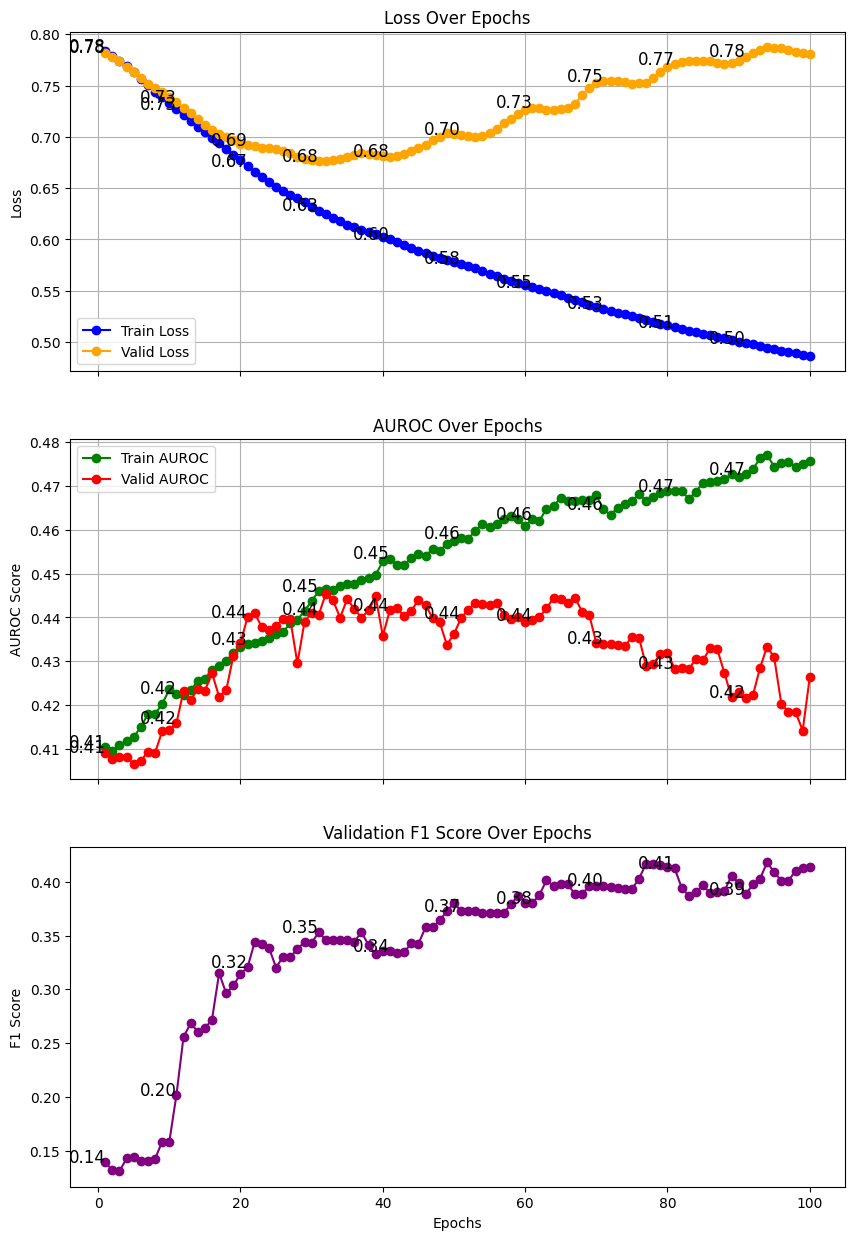

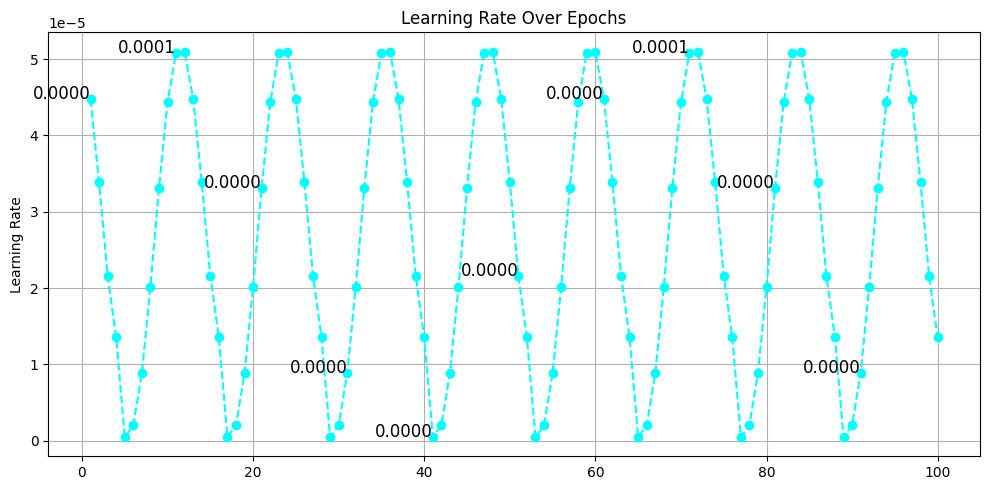

In [27]:
plot_metrics(history)

In [28]:
torch.softmax(model(gt.to(CONFIG['device']), pred.to(CONFIG['device'])), dim=1)

tensor([[0.0059, 0.3959, 0.5600, 0.0382],
        [0.0971, 0.4525, 0.3401, 0.1103],
        [0.0014, 0.2715, 0.5003, 0.2268],
        [0.0135, 0.3794, 0.5703, 0.0368],
        [0.0603, 0.3290, 0.5186, 0.0920],
        [0.0011, 0.3292, 0.4373, 0.2324],
        [0.0543, 0.4331, 0.3942, 0.1183],
        [0.0214, 0.2342, 0.5548, 0.1896],
        [0.0008, 0.1555, 0.4036, 0.4402],
        [0.1528, 0.5040, 0.2889, 0.0543],
        [0.1478, 0.3715, 0.2699, 0.2108],
        [0.0099, 0.5013, 0.4230, 0.0658],
        [0.2225, 0.4484, 0.2759, 0.0533],
        [0.0485, 0.3275, 0.3297, 0.2943],
        [0.0870, 0.5414, 0.3270, 0.0447],
        [0.1073, 0.4200, 0.3952, 0.0775]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)